In [230]:
# Installs all used packages in our report
# install.packages("corrplot")
# install.packages("dplyr")
# install.packages("stargazer")
# install.packages("ggplot2")
# install.packages("reshape2")
# install.packages("tidyr")
# install.packages("broom")

# Loads packages
library(effsize)
library(dplyr)
library(ggplot2)
library('corrplot')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [231]:
# Imports Data
dfCrime = read.csv("crime_v2.csv")

variable  | label
----------|------
1    county|               county identifier
2      year|                            1987
3    crmrte|     crimes committed per person
4    prbarr|         'probability' of arrest
5   prbconv|     'probability' of conviction
6   prbpris| 'probability' of prison sentence
7    avgsen|             avg. sentence, days
8     polpc|               police per capita
9   density|             people per sq. mile
10    taxpc|          tax revenue per capita
11     west|           =1 if in western N.C.
12  central|           =1 if in central N.C.
13    urban|                   =1 if in SMSA
14 pctmin80|            perc. minority, 1980
15     wcon|       weekly wage, construction
16     wtuc|    wkly wge, trns, util, commun
17     wtrd| wkly wge, whlesle, retail trade
18     wfir|    wkly wge, fin, ins, real est
19     wser|      wkly wge, service industry
20     wmfg|         wkly wge, manufacturing
21     wfed|         wkly wge, fed employees
22     wsta|       wkly wge, state employees
23     wloc|        wkly wge, local gov emps
24      mix| offense mix: face-to-face/other
25  pctymle|              percent young male

In [232]:
# summary(dfCrime)

In [233]:
#unique(dfCrime$prbconv)

In [234]:
# dfCrime[is.na(dfCrime),]
# dfCrime
nrow(dfCrime)

[1] 97

In [235]:
dfCrime <-na.omit(dfCrime) # get rid of the NA rows
nrow(dfCrime)

[1] 91

In [236]:
dfCrime[duplicated(dfCrime),]
# unique(dfCrime$county)

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
89,193,87,0.0235277,0.266055,0.588859022,0.423423,5.86,0.00117887,0.8138298,28.51783,⋯,480.1948,268.3836,365.0196,295.9352,295.63,468.26,337.88,348.74,0.1105016,0.07819394


In [237]:
dfCrime <- dfCrime[!duplicated(dfCrime),] # get rid of the duplicated row
nrow(dfCrime)

[1] 90

In [238]:
dfCrime$prbconv<-as.numeric(levels(dfCrime$prbconv))[dfCrime$prbconv]
#dfCrime$prbconv<-as.double(dfCrime$prbconv)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [239]:
dfCrime$county<-as.factor(dfCrime$county) #note that we're missing 10 counties from NC; 6 were blank rows in this set, one row was a duplicate

In [240]:
dfCrime$pctmin80<-dfCrime$pctmin80/100 # units are off in comparison to pctymle; we either divide by 100 here or multiply the other one

In [269]:
#Map central and west to a region code.
# Note that county 71 has both western and central codes
dfCrime$region <- case_when (
            (dfCrime$central ==0 & dfCrime$west ==0) ~ 0, #Eastern, Coastal, Other
            (dfCrime$central ==0 & dfCrime$west ==1) ~ 1, #Western
            (dfCrime$central ==1 & dfCrime$west ==0) ~ 2, #Central
            (dfCrime$central ==1 & dfCrime$west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be a coding error.
        )

In [267]:
# create a factor for 'central', 'western', 'central/western' and 'eastern, coastal, other' region
# dfCrime$region =
#             factor( dfCrime$region , levels = 0:3 , labels =
#                     c( 'Region 1',
#                        'Region 2',
#                        'Region 3',
#                        'Region 4'
#                       )
#                    )

In [243]:
# create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
#    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
dfCrime$metro =
            factor( dfCrime$urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   )

In [244]:
dfCrime$wage <-  dfCrime$wcon + dfCrime$wtuc + dfCrime$wtrd + dfCrime$wfir + dfCrime$wser + dfCrime$wmfg + dfCrime$wfed + dfCrime$wsta + dfCrime$wloc

summary(dfCrime$wage)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2338    2721    2906    2953    3107    4464 

In [245]:
# Need to remove rows with probability of arrest and conviction > 1
dfCrime = dfCrime[dfCrime['prbarr'] < 1,]
dfCrime = dfCrime[dfCrime['prbconv'] < 1,]

In [246]:
dfCrime$prbcrmjustice <- dfCrime$prbconv * dfCrime$prbarr
# dfCrime$logprbcrmjustice <- log10(dfCrime$logprbcrmjustice)

summary(dfCrime$prbcrmjustice)
head(dfCrime[order(-dfCrime$prbcrmjustice),])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03587 0.08432 0.11956 0.13045 0.15963 0.34146 

,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wmfg,wfed,wsta,wloc,mix,pctymle,region,metro,wage,prbcrmjustice
58,131,87,0.0189848,0.689024,0.495575,0.401786,9.97,0.00121549,0.4126394,37.70006,⋯,278.70,432.81,370.81,259.78,0.16725978,0.08356434,Region 1,Outside,2644.494,0.3414631
8,15,87,0.0202814,0.392111,0.769231,0.507692,10.64,0.00103525,0.3009986,34.00304,⋯,235.05,416.49,370.62,297.13,0.23495702,0.07430546,Region 1,Outside,2687.745,0.3016239
18,39,87,0.0119154,0.308333,0.972973,0.291667,11.58,0.00119154,0.4623894,27.27564,⋯,270.78,397.33,313.06,239.17,0.13744076,0.06973287,Region 2,Outside,2610.024,0.2999997
52,117,87,0.0268723,0.370474,0.793233,0.236967,11.83,0.00119765,0.5813449,38.81493,⋯,327.29,383.88,360.66,302.03,0.07485030,0.07632116,Region 1,Outside,2719.372,0.2938722
77,169,87,0.0121033,0.343387,0.722973,0.448598,12.36,0.00109520,0.8008850,37.70785,⋯,306.42,406.62,348.37,306.68,0.13720317,0.08280677,Region 3,Outside,3031.232,0.2482595
5,9,87,0.0106232,0.518219,0.476563,0.442623,8.22,0.00086018,0.5469484,28.05474,⋯,290.89,377.35,367.23,342.82,0.06008584,0.07069755,Region 2,Outside,2759.238,0.2469640


In [247]:
dfCrime$logcrmrte = log10(dfCrime$crmrte)
dfCrime$logprbconv = log10(dfCrime$prbconv)
dfCrime$logprbarr = log10(dfCrime$prbarr)
dfCrime$logprbcrmjustice = log10(dfCrime$prbcrmjustice)

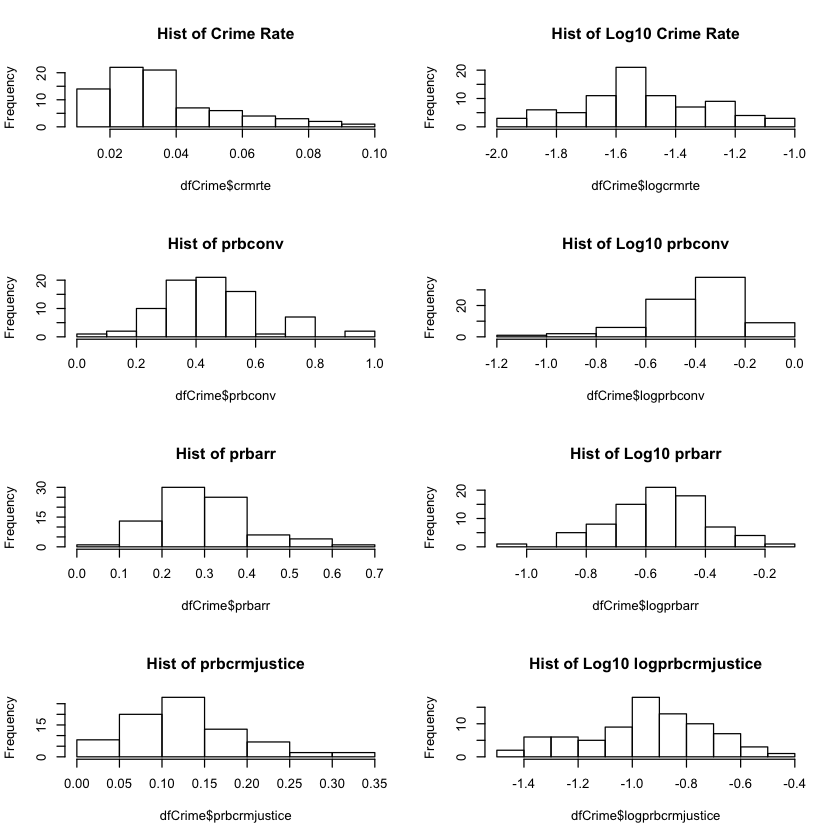

In [248]:
par(mfrow = c(4,2))
hist(dfCrime$crmrte, main="Hist of Crime Rate")
hist(dfCrime$logcrmrte, main="Hist of Log10 Crime Rate")
hist(dfCrime$prbconv, main="Hist of prbconv")
hist(dfCrime$logprbconv, main="Hist of Log10 prbconv")
hist(dfCrime$prbarr, main="Hist of prbarr")
hist(dfCrime$logprbarr, main="Hist of Log10 prbarr")
hist(dfCrime$prbcrmjustice, main="Hist of prbcrmjustice")
hist(dfCrime$logprbcrmjustice, main="Hist of Log10 logprbcrmjustice")

## model 1

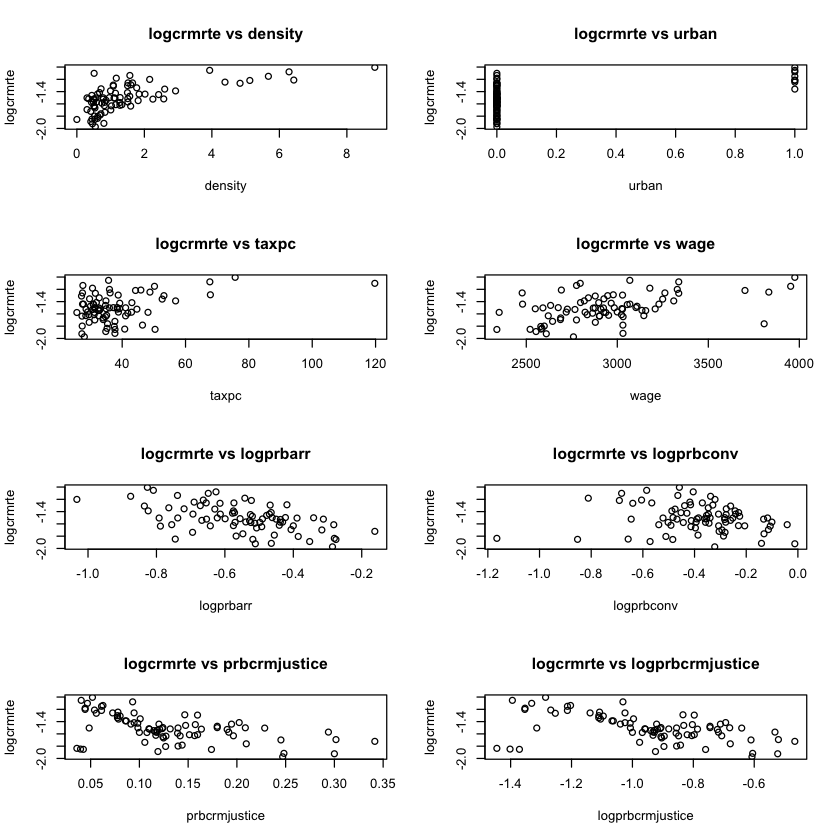

In [249]:
par(mfrow = c(4,2))
plot(dfCrime$density, dfCrime$logcrmrte, main = 'logcrmrte vs density', xlab='density', ylab='logcrmrte')

plot(dfCrime$urban, dfCrime$logcrmrte, main = 'logcrmrte vs urban', xlab='urban', ylab='logcrmrte')

plot(dfCrime$taxpc, dfCrime$logcrmrte, main = 'logcrmrte vs taxpc', xlab='taxpc', ylab='logcrmrte')

plot(dfCrime$wage, dfCrime$logcrmrte, main = 'logcrmrte vs wage', xlab='wage', ylab='logcrmrte')

plot(dfCrime$logprbarr, dfCrime$logcrmrte, main = 'logcrmrte vs logprbarr', xlab='logprbarr', ylab='logcrmrte')

plot(dfCrime$logprbconv, dfCrime$logcrmrte, main = 'logcrmrte vs logprbconv', xlab='logprbconv', ylab='logcrmrte')

plot(dfCrime$prbcrmjustice, dfCrime$logcrmrte, main = 'logcrmrte vs prbcrmjustice', xlab='prbcrmjustice', ylab='logcrmrte')

plot(dfCrime$logprbcrmjustice, dfCrime$logcrmrte, main = 'logcrmrte vs logprbcrmjustice', xlab='logprbcrmjustice', ylab='logcrmrte')


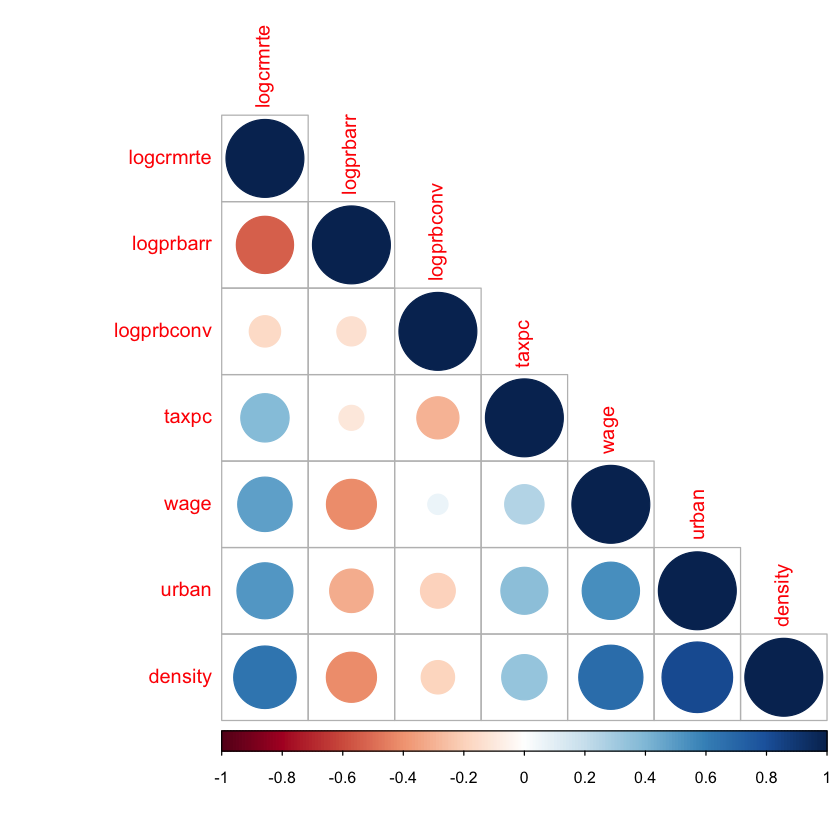

In [255]:
corrplot(cor(dfCrime[,c("logcrmrte", "logprbarr", "logprbconv","taxpc", "wage", "urban", "density")]),method='circle', type = 'lower')


In [251]:
#mod1 using logprbarr and logprbconv separately
mod1 <- lm(logcrmrte ~ logprbarr + logprbconv + density + taxpc, data = dfCrime)
mod1

summary(mod1)

#residuals: difference between the actual 
#observed resposne values (crmrate to crmjustice + taxpc)
#and the respionse values that the model predicted



Call:
lm(formula = logcrmrte ~ logprbarr + logprbconv + density + taxpc, 
    data = dfCrime)

Coefficients:
(Intercept)    logprbarr   logprbconv      density        taxpc  
  -2.019214    -0.492363    -0.095962     0.058127     0.003021  



Call:
lm(formula = logcrmrte ~ logprbarr + logprbconv + density + taxpc, 
    data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40748 -0.07056  0.01227  0.08305  0.33304 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.019214   0.087448 -23.090  < 2e-16 ***
logprbarr   -0.492363   0.120576  -4.083  0.00011 ***
logprbconv  -0.095962   0.098790  -0.971  0.33449    
density      0.058127   0.012761   4.555 1.99e-05 ***
taxpc        0.003021   0.001413   2.138  0.03582 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1523 on 75 degrees of freedom
Multiple R-squared:  0.547,	Adjusted R-squared:  0.5228 
F-statistic: 22.64 on 4 and 75 DF,  p-value: 2.74e-12


In [252]:
# model 1b...using logprbcrmjustice
mod1b <- lm(logcrmrte ~ logprbcrmjustice + density + taxpc, data = dfCrime)
mod1b
summary(mod1b)




Call:
lm(formula = logcrmrte ~ logprbcrmjustice + density + taxpc, 
    data = dfCrime)

Coefficients:
     (Intercept)  logprbcrmjustice           density             taxpc  
       -1.926037         -0.243350          0.067273          0.002353  



Call:
lm(formula = logcrmrte ~ logprbcrmjustice + density + taxpc, 
    data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41398 -0.05947  0.00282  0.10233  0.32570 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -1.926037   0.085230 -22.598  < 2e-16 ***
logprbcrmjustice -0.243350   0.088795  -2.741  0.00764 ** 
density           0.067273   0.012956   5.192 1.68e-06 ***
taxpc             0.002353   0.001461   1.610  0.11148    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1596 on 76 degrees of freedom
Multiple R-squared:  0.496,	Adjusted R-squared:  0.4762 
F-statistic: 24.94 on 3 and 76 DF,  p-value: 2.459e-11


## model 2

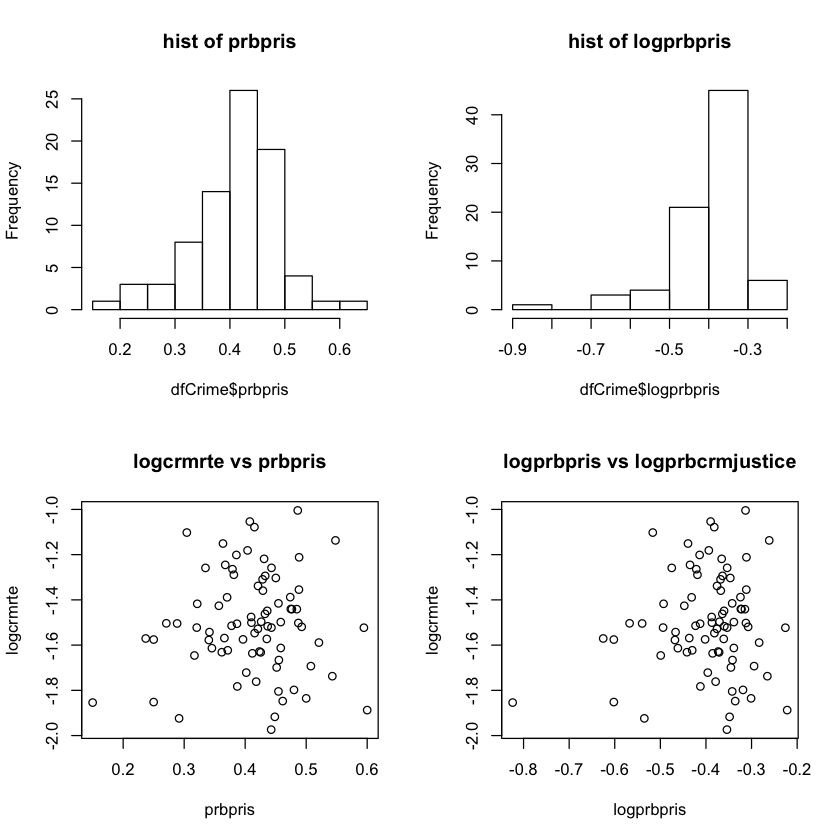

In [260]:
dfCrime$logprbpris <- log10(dfCrime$prbpris)
par(mfrow = c(2,2))
hist(dfCrime$prbpris, main="hist of prbpris")
hist(dfCrime$logprbpris, main="hist of logprbpris")
plot(dfCrime$prbpris, dfCrime$logcrmrte, main = 'logcrmrte vs prbpris', xlab='prbpris', ylab='logcrmrte')
plot(dfCrime$logprbpris, dfCrime$logcrmrte, main = 'logprbpris vs logprbcrmjustice', xlab='logprbpris', ylab='logcrmrte')

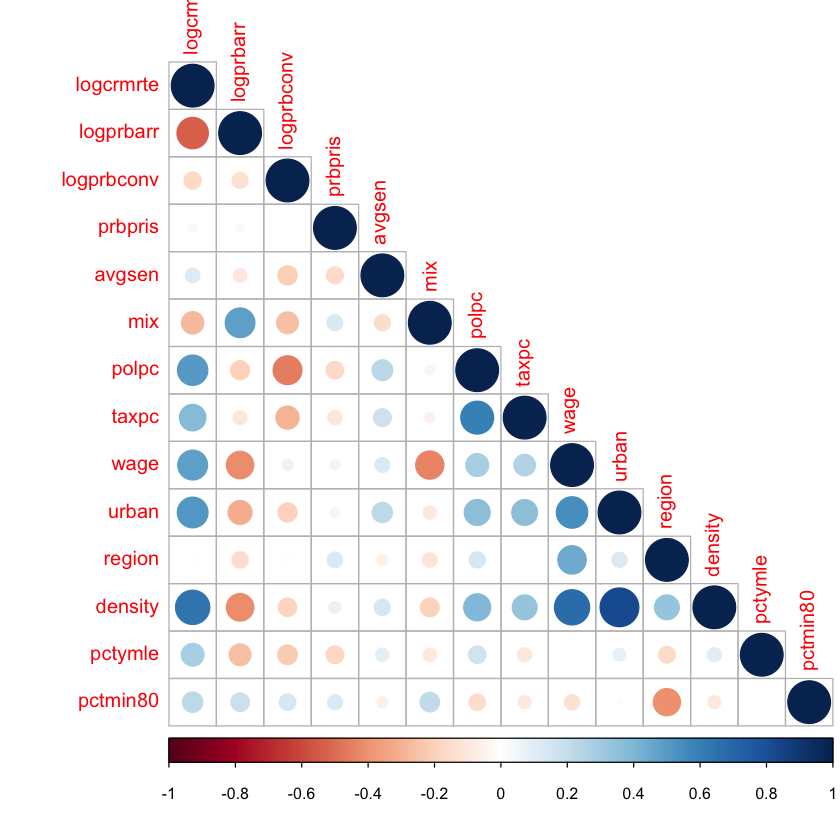

In [270]:


corrplot(cor(dfCrime[,c("logcrmrte", "logprbarr", "logprbconv", "prbpris", "avgsen", "mix", "polpc", "taxpc", "wage", "urban", "region", "density", "pctymle", "pctmin80")]),method='circle', type = 'lower')


In [271]:
# list out high leverage points and rerun with 
# augment find broom package in tidy
# create new column for dummy variable 0,1 (maybe a package for this?)
# https://stats.idre.ucla.edu/r/modules/coding-for-categorical-variables-in-regression-models/

mod2 <- lm(logcrmrte ~ logprbarr + logprbconv + mix + polpc + taxpc + wage + density + region + pctmin80 + pctymle , data = dfCrime)
mod2

summary(mod2)



Call:
lm(formula = logcrmrte ~ logprbarr + logprbconv + mix + polpc + 
    taxpc + wage + density + region + pctmin80 + pctymle, data = dfCrime)

Coefficients:
(Intercept)    logprbarr   logprbconv          mix        polpc        taxpc  
 -2.282e+00   -4.304e-01   -8.587e-02   -3.893e-01    1.085e+02    1.375e-03  
       wage      density       region     pctmin80      pctymle  
  1.942e-05    5.011e-02   -1.094e-02    5.195e-01    8.594e-01  



Call:
lm(formula = logcrmrte ~ logprbarr + logprbconv + mix + polpc + 
    taxpc + wage + density + region + pctmin80 + pctymle, data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29614 -0.07345  0.01692  0.07412  0.21042 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.282e+00  2.110e-01 -10.817  < 2e-16 ***
logprbarr   -4.304e-01  1.090e-01  -3.949 0.000187 ***
logprbconv  -8.587e-02  9.073e-02  -0.946 0.347214    
mix         -3.893e-01  2.106e-01  -1.848 0.068846 .  
polpc        1.085e+02  3.633e+01   2.986 0.003910 ** 
taxpc        1.375e-03  1.364e-03   1.008 0.317174    
wage         1.942e-05  6.564e-05   0.296 0.768231    
density      5.011e-02  1.294e-02   3.871 0.000243 ***
region      -1.094e-02  1.893e-02  -0.578 0.564994    
pctmin80     5.195e-01  9.352e-02   5.555 4.85e-07 ***
pctymle      8.594e-01  6.430e-01   1.337 0.185769    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residua

In [272]:
mod2b <- lm(logcrmrte ~ logprbcrmjustice + mix + polpc + taxpc + wage + density + region + pctmin80 + pctymle , data = dfCrime)
mod2b

summary(mod2b)


Call:
lm(formula = logcrmrte ~ logprbcrmjustice + mix + polpc + taxpc + 
    wage + density + region + pctmin80 + pctymle, data = dfCrime)

Coefficients:
     (Intercept)  logprbcrmjustice               mix             polpc  
      -2.227e+00        -2.167e-01        -6.214e-01         1.006e+02  
           taxpc              wage           density            region  
       9.787e-04         4.014e-05         5.312e-02        -1.089e-02  
        pctmin80           pctymle  
       5.285e-01         9.227e-01  



Call:
lm(formula = logcrmrte ~ logprbcrmjustice + mix + polpc + taxpc + 
    wage + density + region + pctmin80 + pctymle, data = dfCrime)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33621 -0.07587  0.03184  0.07464  0.20837 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -2.227e+00  2.201e-01 -10.122 2.40e-15 ***
logprbcrmjustice -2.167e-01  8.142e-02  -2.662 0.009629 ** 
mix              -6.214e-01  2.028e-01  -3.065 0.003094 ** 
polpc             1.006e+02  3.794e+01   2.651 0.009916 ** 
taxpc             9.787e-04  1.421e-03   0.689 0.493409    
wage              4.014e-05  6.833e-05   0.587 0.558801    
density           5.312e-02  1.351e-02   3.931 0.000197 ***
region           -1.089e-02  1.983e-02  -0.549 0.584698    
pctmin80          5.285e-01  9.791e-02   5.398 8.72e-07 ***
pctymle           9.227e-01  6.732e-01   1.371 0.174857    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual stan